In [16]:
import numpy as np
import pandas as pd
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
from copy import deepcopy

#from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KernelDensity
from econml.dml import CausalForestDML

import warnings
warnings.filterwarnings("ignore")

def fullDisplay():
    pd.set_option("display.max_rows", None, "display.max_columns", None)

def defaultDisplay():
    pd.reset_option('^display.', silent=True)

warnings.filterwarnings('ignore')

In [21]:
# w = 0 means the question had "assistance", w = 1 means the question had "welfare"
# y = 0 means the responder said no, y = 1 means yes
welfare_raw = pd.read_csv("Data/welfare_clean.csv", low_memory=False)
labels = welfare_raw['y'].values
treatments = welfare_raw['w']
treatments = treatments.replace({0:1, 1:0}) # we want 1 to be assistance, and 0 to be welfare, so if the TE is positive then it means people responded favorably to assistance
welfare_raw

,year,id,wrkstat,hrs1,hrs2,evwork,occ,prestige,wrkslf,wrkgovt,...,earnrs_miss,income_miss,rincome_miss,income86_miss,partyid_miss,polviews_miss,attblack,attblack_miss,w,y
0,0,1,7,0.004845,0.005228,1,135,0.005641,2,2,...,0,0,0,0,0,0,0.005440,0,1,0
1,0,2,1,0.005055,0.005228,0,106,0.006538,2,2,...,0,0,1,0,0,0,0.004080,0,1,1
2,0,3,7,0.004845,0.005228,1,99,0.006538,2,2,...,0,0,0,0,0,0,0.002040,0,1,1
3,0,4,3,0.005055,0.005228,0,142,0.004615,2,0,...,0,0,1,0,0,0,0.004080,0,1,0
4,0,5,8,0.005055,0.005228,1,211,0.005171,2,1,...,0,0,0,0,0,0,0.004080,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36496,15,2040,3,0.005055,0.005228,0,211,0.005171,2,2,...,0,0,1,1,0,0,0.004080,0,1,0
36497,15,2041,3,0.005055,0.005228,0,211,0.005171,2,2,...,0,0,1,1,0,0,0.006120,0,1,1
36498,15,2042,7,0.004845,0.005228,1,211,0.005171,2,2,...,0,0,0,1,0,0,0.004080,0,0,0
36499,15,2043,7,0.005935,0.005228,1,211,0.005171,2,2,...,0,0,1,1,0,0,0.005021,1,1,0


array([[<AxesSubplot:title={'center':'educ'}>]], dtype=object)

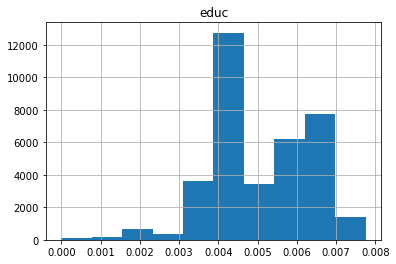

In [22]:
welfaredf = pd.DataFrame(welfare_raw)
welfaredf.hist(column = 'educ')

In [23]:
# Fit a kernel density model using GridSearchCV to determine the best parameter for bandwidth
bandwidth_params = {'bandwidth': np.arange(0.01,1,0.05)}
grid_search = GridSearchCV(KernelDensity(), bandwidth_params)
grid_search.fit(welfare_raw)
kde = grid_search.best_estimator_

# # Generate/sample 8 new faces from this dataset
# new_faces = kde.sample(8, random_state=rand_state)

# # Show a sample of 8 original face images and 8 generated faces derived from the faces dataset
# fig,ax = plt.subplots(nrows=2, ncols=8,figsize=(18,6),subplot_kw=dict(xticks=[], yticks=[]))
# for i in np.arange(8):
#     ax[0,i].imshow(X[10*i,:].reshape(64,64),cmap=plt.cm.gray)   
#     ax[1,i].imshow(new_faces[i,:].reshape(64,64),cmap=plt.cm.gray)    
# ax[0,3].set_title('Original Data',fontsize=20)
# ax[1,3].set_title('Synthetic Data',fontsize=20)
# fig.subplots_adjust(wspace=.1)
# plt.show()


In [36]:
kde
import joblib
joblib.dump(grid_search, 'Data/test_GridSearch_vee.pkl')
joblib.dump(kde, 'Data/test_kde_vee.pkl')
test_kde = joblib.load('Data/test_kde_vee.pkl')

In [ ]:
BETA = 10 

df = data['df']
X = df.drop(['y'], axis=1)
Y = df['y']
T = df['v0']
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.2)
        
# specify hyperparams of model
est = CausalForest(criterion='mse', n_estimators=1000,       
                        min_samples_leaf=1, 
                        max_depth=100, max_samples=0.5,
                        honest=True, inference=True)

# fit model
est.fit(X_train, T_train, Y_train)

predict, sigma = est.predict_and_var(X_test)

est, predict, sigma

In [ ]:
def estimate_cf(y, X, treatments, test_size=0.2, criterion='mse', cv=5):
    # split data into train and test sets 
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, y, treatments, test_size=test_size)
        
    # specify hyperparams of model
    est = CausalForestDML(criterion='het', 
                            n_estimators=1000,       
                            max_samples=0.5,
                            discrete_treatment=True,
                            honest=True,
                            inference=True,
                            cv=cv,
                            )
    # fit model
    est.fit(Y_train, T_train, X=X_train, W=None)
        
    return est, X_test

In [ ]:
est_general, X_test_general = estimate_cf(labels, welfare, treatments)
est_general.ate_inference(X_test_general)